<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/transfer_learning_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.8.0+cu126
Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}


In [ ]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True if x=="train" else False, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


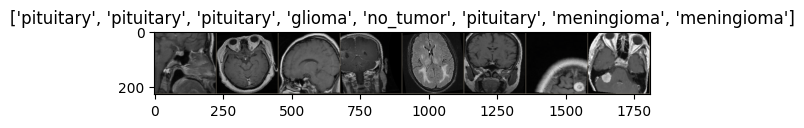

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Total params: 11178564
Total Trainable Parameters: 2052


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
NUM_EPOCHS = 50
best_val_acc = 0.0
best_model_path = 'resnet18_clsf_head.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/50


    train_loss: 1.0650    train_acc: 0.5528
    val_loss: 0.7695    val_acc: 0.6614
Saved new best model
Epoch 2/50


    train_loss: 0.7800    train_acc: 0.7062
    val_loss: 0.5906    val_acc: 0.7789
Saved new best model
Epoch 3/50


    train_loss: 0.7150    train_acc: 0.7180
    val_loss: 0.5349    val_acc: 0.7749
Epoch 4/50


    train_loss: 0.6790    train_acc: 0.7339
    val_loss: 0.4231    val_acc: 0.8406
Saved new best model
Epoch 5/50


    train_loss: 0.6794    train_acc: 0.7451
    val_loss: 0.5621    val_acc: 0.7769
Epoch 6/50


    train_loss: 0.6453    train_acc: 0.7410
    val_loss: 0.4151    val_acc: 0.8506
Saved new best model
Epoch 7/50


    train_loss: 0.6749    train_acc: 0.7381
    val_loss: 0.3789    val_acc: 0.8645
Saved new best model
Epoch 8/50


    train_loss: 0.6844    train_acc: 0.7286
    val_loss: 0.4164    val_acc: 0.8426
Epoch 9/50


    train_loss: 0.6424    train_acc: 0.7504
    val_loss: 0.4656    val_acc: 0.8307
Epoch 10/50


    train_loss: 0.6231    train_acc: 0.7493
    val_loss: 0.3964    val_acc: 0.8606
Epoch 11/50


    train_loss: 0.6493    train_acc: 0.7552
    val_loss: 0.5111    val_acc: 0.7888
Epoch 12/50


    train_loss: 0.6004    train_acc: 0.7735
    val_loss: 0.3645    val_acc: 0.8725
Saved new best model
Epoch 13/50


    train_loss: 0.6336    train_acc: 0.7546
    val_loss: 0.4175    val_acc: 0.8446
Epoch 14/50


    train_loss: 0.5629    train_acc: 0.7823
    val_loss: 0.3407    val_acc: 0.8924
Saved new best model
Epoch 15/50


    train_loss: 0.6107    train_acc: 0.7729
    val_loss: 0.3671    val_acc: 0.8785
Epoch 16/50


    train_loss: 0.5722    train_acc: 0.7776
    val_loss: 0.3782    val_acc: 0.8685
Epoch 17/50


    train_loss: 0.5779    train_acc: 0.7758
    val_loss: 0.3755    val_acc: 0.8785
Epoch 18/50


    train_loss: 0.5927    train_acc: 0.7729
    val_loss: 0.3676    val_acc: 0.8805
Epoch 19/50


    train_loss: 0.5732    train_acc: 0.7805
    val_loss: 0.3475    val_acc: 0.8924
Epoch 20/50


    train_loss: 0.5603    train_acc: 0.7817
    val_loss: 0.3455    val_acc: 0.8805
Epoch 21/50


    train_loss: 0.6074    train_acc: 0.7770
    val_loss: 0.3293    val_acc: 0.8944
Saved new best model
Epoch 22/50


    train_loss: 0.5458    train_acc: 0.7923
    val_loss: 0.3716    val_acc: 0.8685
Epoch 23/50


    train_loss: 0.5433    train_acc: 0.7906
    val_loss: 0.3262    val_acc: 0.8984
Saved new best model
Epoch 24/50


    train_loss: 0.5584    train_acc: 0.7894
    val_loss: 0.3710    val_acc: 0.8606
Epoch 25/50


    train_loss: 0.5754    train_acc: 0.7788
    val_loss: 0.4047    val_acc: 0.8506
Epoch 26/50


    train_loss: 0.5755    train_acc: 0.7782
    val_loss: 0.3845    val_acc: 0.8466
Epoch 27/50


    train_loss: 0.5497    train_acc: 0.7894
    val_loss: 0.3254    val_acc: 0.8964
Epoch 28/50


    train_loss: 0.5538    train_acc: 0.7917
    val_loss: 0.3324    val_acc: 0.8805
Epoch 29/50


    train_loss: 0.5500    train_acc: 0.7853
    val_loss: 0.3393    val_acc: 0.8805
Epoch 30/50


    train_loss: 0.5321    train_acc: 0.7982
    val_loss: 0.3513    val_acc: 0.8665
Epoch 31/50


    train_loss: 0.5541    train_acc: 0.7917
    val_loss: 0.3149    val_acc: 0.8904
Epoch 32/50


    train_loss: 0.5628    train_acc: 0.7817
    val_loss: 0.3138    val_acc: 0.8944
Epoch 33/50


    train_loss: 0.5653    train_acc: 0.7906
    val_loss: 0.3584    val_acc: 0.8765
Epoch 34/50


    train_loss: 0.5637    train_acc: 0.7799
    val_loss: 0.3233    val_acc: 0.8884
Epoch 35/50


    train_loss: 0.5861    train_acc: 0.7782
    val_loss: 0.3879    val_acc: 0.8526
Epoch 36/50


    train_loss: 0.5738    train_acc: 0.7876
    val_loss: 0.3558    val_acc: 0.8785
Epoch 37/50


    train_loss: 0.5522    train_acc: 0.7764
    val_loss: 0.3295    val_acc: 0.8904
Epoch 38/50


    train_loss: 0.5519    train_acc: 0.7947
    val_loss: 0.3283    val_acc: 0.8785
Epoch 39/50


    train_loss: 0.5778    train_acc: 0.7829
    val_loss: 0.3221    val_acc: 0.8884
Epoch 40/50


    train_loss: 0.5329    train_acc: 0.7876
    val_loss: 0.3300    val_acc: 0.8785
Epoch 41/50


    train_loss: 0.5654    train_acc: 0.7929
    val_loss: 0.3318    val_acc: 0.8765
Epoch 42/50


    train_loss: 0.5450    train_acc: 0.7882
    val_loss: 0.3300    val_acc: 0.8865
Epoch 43/50


    train_loss: 0.5663    train_acc: 0.7976
    val_loss: 0.3167    val_acc: 0.8884
Epoch 44/50


    train_loss: 0.5345    train_acc: 0.8136
    val_loss: 0.3360    val_acc: 0.8805
Epoch 45/50


    train_loss: 0.5593    train_acc: 0.7758
    val_loss: 0.3236    val_acc: 0.8904
Epoch 46/50


    train_loss: 0.5474    train_acc: 0.7835
    val_loss: 0.3664    val_acc: 0.8546
Epoch 47/50


    train_loss: 0.5647    train_acc: 0.7799
    val_loss: 0.3239    val_acc: 0.8865
Epoch 48/50


    train_loss: 0.5428    train_acc: 0.7976
    val_loss: 0.3175    val_acc: 0.8924
Epoch 49/50


    train_loss: 0.5446    train_acc: 0.7894
    val_loss: 0.3106    val_acc: 0.9024
Saved new best model
Epoch 50/50


    train_loss: 0.5377    train_acc: 0.7959
    val_loss: 0.3360    val_acc: 0.8825
Training Complete in 21.55 minutes. Best val acc: 0.9024'


Final validation loss: 0.3106, acc: 0.9024
Confusion Matrix:
 [[154   5   1   1]
 [  4  96  13  11]
 [  1   4  91   3]
 [  1   3   2 112]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9625    0.9565    0.9595       161
  meningioma     0.8889    0.7742    0.8276       124
    no_tumor     0.8505    0.9192    0.8835        99
   pituitary     0.8819    0.9492    0.9143       118

    accuracy                         0.9024       502
   macro avg     0.8959    0.8998    0.8962       502
weighted avg     0.9033    0.9024    0.9013       502



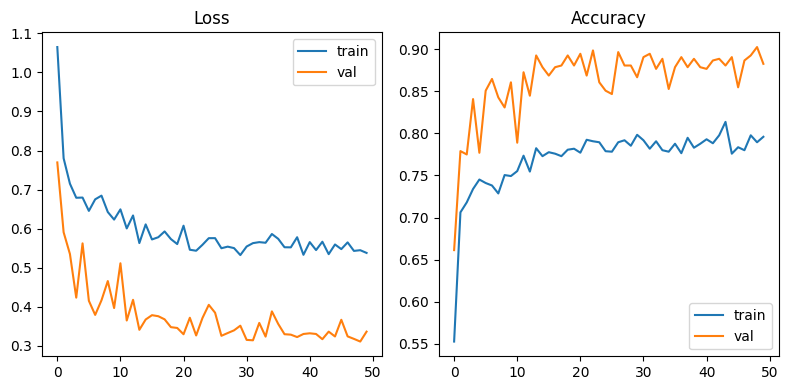

In [11]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

In [ ]:
checkpoint = torch.load('/content/resnet18_clsf_head.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])

for param in model.parameters():
    param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-5, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
print("Now fine-tuning full model...")

NUM_EPOCHS = 20
best_val_acc = 0.0
best_model_path = 'finetuned_resnet18.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Now fine-tuning full model...
Epoch 1/20


    train_loss: 0.5312    train_acc: 0.7971
    val_loss: 0.2761    val_acc: 0.9004
Saved new best model
Epoch 2/20


    train_loss: 0.4781    train_acc: 0.8260
    val_loss: 0.2558    val_acc: 0.9183
Saved new best model
Epoch 3/20


    train_loss: 0.4207    train_acc: 0.8466
    val_loss: 0.2275    val_acc: 0.9243
Saved new best model
Epoch 4/20


    train_loss: 0.3936    train_acc: 0.8566
    val_loss: 0.1941    val_acc: 0.9323
Saved new best model
Epoch 5/20


    train_loss: 0.3442    train_acc: 0.8743
    val_loss: 0.2044    val_acc: 0.9263
Epoch 6/20


    train_loss: 0.3454    train_acc: 0.8791
    val_loss: 0.1729    val_acc: 0.9382
Saved new best model
Epoch 7/20


    train_loss: 0.3422    train_acc: 0.8767
    val_loss: 0.1836    val_acc: 0.9442
Saved new best model
Epoch 8/20


    train_loss: 0.3366    train_acc: 0.8814
    val_loss: 0.1595    val_acc: 0.9502
Saved new best model
Epoch 9/20


    train_loss: 0.3303    train_acc: 0.8755
    val_loss: 0.1325    val_acc: 0.9602
Saved new best model
Epoch 10/20


    train_loss: 0.3105    train_acc: 0.8962
    val_loss: 0.1338    val_acc: 0.9582
Epoch 11/20


    train_loss: 0.2741    train_acc: 0.9127
    val_loss: 0.1330    val_acc: 0.9602
Epoch 12/20


    train_loss: 0.2885    train_acc: 0.8979
    val_loss: 0.1272    val_acc: 0.9681
Saved new best model
Epoch 13/20


    train_loss: 0.2841    train_acc: 0.8985
    val_loss: 0.1577    val_acc: 0.9542
Epoch 14/20


    train_loss: 0.2152    train_acc: 0.9268
    val_loss: 0.1320    val_acc: 0.9701
Saved new best model
Epoch 15/20


    train_loss: 0.2399    train_acc: 0.9174
    val_loss: 0.1311    val_acc: 0.9582
Epoch 16/20


    train_loss: 0.2422    train_acc: 0.9156
    val_loss: 0.1287    val_acc: 0.9622
Epoch 17/20


    train_loss: 0.2479    train_acc: 0.9150
    val_loss: 0.1481    val_acc: 0.9462
Epoch 18/20


    train_loss: 0.2315    train_acc: 0.9162
    val_loss: 0.1281    val_acc: 0.9641
Epoch 19/20


    train_loss: 0.2279    train_acc: 0.9156
    val_loss: 0.1257    val_acc: 0.9641
Epoch 20/20


    train_loss: 0.2054    train_acc: 0.9274
    val_loss: 0.1391    val_acc: 0.9641
Training Complete in 7.00 minutes. Best val acc: 0.9701'


In [18]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.1320, acc: 0.9701


Confusion Matrix:
 [[160   1   0   0]
 [  1 113   5   5]
 [  0   1  97   1]
 [  0   1   0 117]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9938    0.9938    0.9938       161
  meningioma     0.9741    0.9113    0.9417       124
    no_tumor     0.9510    0.9798    0.9652        99
   pituitary     0.9512    0.9915    0.9710       118

    accuracy                         0.9701       502
   macro avg     0.9675    0.9691    0.9679       502
weighted avg     0.9705    0.9701    0.9699       502



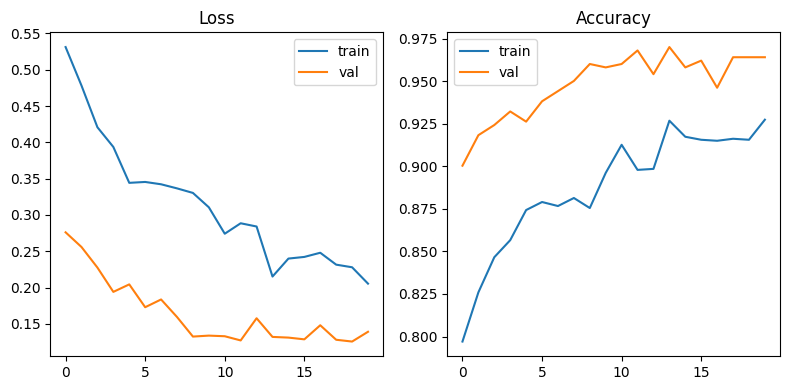

In [19]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()